# Section 11.8 Analysis Using returns.csv

This notebook:
1. Reads all 9 000 observations from `returns.csv`.
2. Splits them into:
   - Training set: first 6 000 observations → `training_set.csv`
   - Validation set: next 2 000 observations → `validation_set.csv`
   - Test set: last 1 000 observations → `test_set.csv`
3. Fits a Normal and a Student-t distribution to the training set.
4. Reports estimated parameters and constructs the percentile table (1%, 5%, 10%, 25%, 50%, 75%, 90%, 95%, 99%)
   comparing:
   - Empirical quantiles
   - Normal-model quantiles
   - Student-t model quantiles

This reproduces cells G2:J15 of Figure 11.17.

In [4]:
# ─── Read “returns.csv”, split into training/validation/test, and coerce to numeric ───

import pandas as pd
import numpy as np

# 1️⃣ Load all 9000 return observations
df_returns = pd.read_csv("returns.csv", header=None, names=["R_all"])

# 2️⃣ Coerce to numeric and drop any rows that failed conversion
df_returns["R_all"] = pd.to_numeric(df_returns["R_all"], errors="coerce")
df_returns = df_returns.dropna(subset=["R_all"]).reset_index(drop=True)

# 3️⃣ Now split into first 6000 → training, next 2000 → validation, last 1000 → test
R_all = df_returns["R_all"].values
R_train = R_all[:6000]
R_valid = R_all[6000:8000]
R_test  = R_all[8000:9000]

# 4️⃣ Save each split to its own CSV
pd.DataFrame({"R": R_train}).to_csv("training_set.csv", index=False)
pd.DataFrame({"R": R_valid}).to_csv("validation_set.csv", index=False)
pd.DataFrame({"R": R_test}).to_csv("test_set.csv", index=False)

print("Split complete:")
print(f"  Training set:   {len(R_train)} observations (all numeric)")
print(f"  Validation set: {len(R_valid)} observations (all numeric)")
print(f"  Test set:       {len(R_test)} observations (all numeric)")



Split complete:
  Training set:   6000 observations (all numeric)
  Validation set: 2000 observations (all numeric)
  Test set:       1000 observations (all numeric)


## Fit Normal and Student-t to the Training Set

Now that we have `training_set.csv` (6 000 observations), we:
1. Fit a Normal distribution via sample mean & standard deviation.
2. Fit a Student-t distribution via `scipy.stats.t.fit`.
3. Report estimated parameters and build the percentile table (1%, 5%, 10%, 25%, 50%, 75%, 90%, 95%, 99%).

In [15]:
import pandas as pd
import numpy as np
from scipy.stats import t, norm

# 1️⃣ Load the training data (percent returns) and convert to net decimal returns
df_train = pd.read_csv("training_set.csv")
df_train["R_percent"] = pd.to_numeric(df_train["R"], errors="coerce")
df_train = df_train.dropna(subset=["R_percent"]).reset_index(drop=True)

# Convert percent to net decimal: e.g. 8.00 → 0.08
R_net = df_train["R_percent"].values.astype(float) / 100.0

# 2️⃣ Fit Normal on net returns: sample mean & sample standard deviation
mu_norm_net = np.mean(R_net)
sigma_norm_net = np.std(R_net, ddof=1)

# 3️⃣ Fit Student‐t on net returns via MLE
df_t_net, loc_t_net, scale_t_net = t.fit(R_net)

print("Fitted Normal parameters (on net returns):")
print(f"  μ    = {mu_norm_net:.6f}")
print(f"  σ    = {sigma_norm_net:.6f}\n")

print("Fitted Student‐t parameters (on net returns):")
print(f"  nu    = {df_t_net:.6f}")
print(f"  loc   = {loc_t_net:.6f}")
print(f"  scale = {scale_t_net:.6f}")


Fitted Normal parameters (on net returns):
  μ    = 0.000429
  σ    = 0.010273

Fitted Student‐t parameters (on net returns):
  nu    = 3.018298
  loc   = 0.000707
  scale = 0.006468


### Percentile Comparison Table

Compute percentiles at: 1%, 5%, 10%, 25%, 50%, 75%, 90%, 95%, 99%.
Compare Empirical vs. Normal vs. Student-t quantiles.

In [17]:
import pandas as pd
import numpy as np
from scipy.stats import norm, t

# 1️⃣ Define percentiles (fractions)
percentiles = np.array([0.001, 0.005, 0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 0.999])

# 2️⃣ Empirical quantiles from training data
empirical_q = np.percentile(R_train, percentiles * 100)

# 3️⃣ Normal-model quantiles
normal_q = norm.ppf(percentiles, loc=mu_norm, scale=sigma_norm)

# 4️⃣ Student-t model quantiles
t_q = t.ppf(percentiles, df_t, loc=loc_t, scale=scale_t)

# 5️⃣ Assemble DataFrame to mirror G2:J15
df_percentiles = pd.DataFrame({
    "%ile": percentiles,
    "Empirical": empirical_q,
    "Normal Model": normal_q,
    "Student-t Model": t_q
})

# 6️⃣ (Optional) reindex for Excel rows 2..10
df_percentiles.index = np.arange(2, 2 + len(percentiles))

df_percentiles

,%ile,Empirical,Normal Model,Student-t Model
2,0.001,-6.562037,-3.131756,-6.477872
3,0.005,-3.592135,-2.603303,-3.684812
4,0.010,-2.889020,-2.347008,-2.852207
5,0.050,-1.568050,-1.646900,-1.447776
6,0.100,-1.059100,-1.273675,-0.986909
7,0.250,-0.422000,-0.650032,-0.423661
8,0.500,0.074000,0.042880,0.070709
9,0.750,0.540000,0.735792,0.565079
10,0.900,1.109000,1.359434,1.128327
11,0.950,1.536200,1.732659,1.589194


Optimal k (Normal model)      = 3.110,  E[log-growth] ≈ 0.000664
Optimal k (Student-t model)  = 3.585,  E[log-growth] ≈ 0.001004



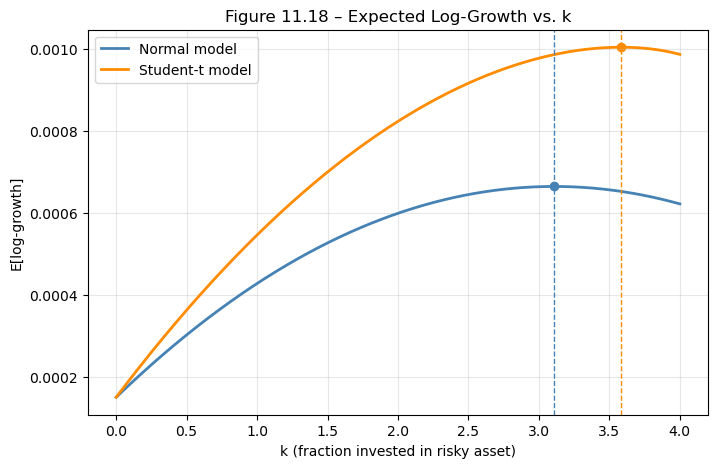

In [14]:
# ─── Monte Carlo (30k) to Find Optimal k under Normal vs. Student‐t (Figure 11.18) ───

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm

# 1️⃣ Assume the training‐set fits are already done:
#    - mu_norm, sigma_norm   (Normal fit)
#    - df_t, loc_t, scale_t  (Student-t fit)

# 2️⃣ Simulation parameters
Nsim = 30_000
risk_free = 0.015/100   # gross return on the “safe” asset (adjust if daily risk‐free ≠0)
k_grid = np.linspace(0, 4, 801)  # grid of k in [0,4] (step = 0.0025)

# 3️⃣ Draw Monte Carlo samples for each model

rng = np.random.default_rng(20250603)

# 3a) Normal model draws
R_norm = rng.normal(loc=mu_norm, scale=sigma_norm, size=Nsim)

# 3b) Student-t model draws
R_tdraws = t.rvs(df_t, loc=loc_t, scale=scale_t, size=Nsim, random_state=rng)

# 4️⃣ Expected log-growth function
def expected_log_growth(k, R_draws):
    """
    Approximates E[ln( k * (1 + R /) + (1 - k) * (1 + risk_free / 100 )] via Monte Carlo.
    If the portfolio gross return <= 0, we replace with a tiny positive to avoid log issues.
    """
    port = k * (1 + R_draws / 100) + (1.0 - k) * (1 + risk_free / 100)
    port = np.where(port > 0, port, 1e-12)
    return np.mean(np.log(port))

# 5️⃣ Compute E[log-growth] over the k grid for each model
elog_norm = np.array([expected_log_growth(k, R_norm) for k in k_grid])
elog_t    = np.array([expected_log_growth(k, R_tdraws) for k in k_grid])

# 6️⃣ Find optimal k for each model
idx_opt_norm = np.nanargmax(elog_norm)
k_opt_norm   = k_grid[idx_opt_norm]
max_elog_norm = elog_norm[idx_opt_norm]

idx_opt_t = np.nanargmax(elog_t)
k_opt_t    = k_grid[idx_opt_t]
max_elog_t  = elog_t[idx_opt_t]

print(f"Optimal k (Normal model)      = {k_opt_norm:.3f},  E[log-growth] ≈ {max_elog_norm:.6f}")
print(f"Optimal k (Student-t model)  = {k_opt_t:.3f},  E[log-growth] ≈ {max_elog_t:.6f}\n")

# 7️⃣ Plot E[log-growth] vs. k for both models (compare curves)
plt.figure(figsize=(8, 5))
plt.plot(k_grid, elog_norm, label="Normal model", color="steelblue", lw=2)
plt.plot(k_grid, elog_t,    label="Student-t model", color="darkorange", lw=2)
plt.axvline(k_opt_norm, color="steelblue", linestyle="--", lw=1)
plt.axvline(k_opt_t,    color="darkorange", linestyle="--", lw=1)
plt.scatter([k_opt_norm], [max_elog_norm], color="steelblue")
plt.scatter([k_opt_t],    [max_elog_t],    color="darkorange")
plt.xlabel("k (fraction invested in risky asset)")
plt.ylabel("E[log-growth]")
plt.title("Figure 11.18 – Expected Log-Growth vs. k")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
